# Lab 2 - AiSec: Federate Learning with security at server

In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

lab_folder = '/content/drive/MyDrive/Đại học/Học kỳ 7/AiSec/Lab2'
model_folder = os.path.join(lab_folder, 'model')
data_folder = os.path.join(lab_folder, 'data')

if not os.path.exists(model_folder):
  os.makedirs(model_folder)

if not os.path.exists(data_folder):
  os.makedirs(data_folder)

# #cd to lab_folder variable
%cd $lab_folder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Đại học/Học kỳ 7/AiSec/Lab2


In [ ]:
code_folder = './code'
data_folder = './data'

## Requirement 1: Read data and show image and labels of CIFAR-10

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Download Data and Know about Dataset

In [ ]:
import torch
import torchvision

In [ ]:
trainset = torchvision.datasets.CIFAR10(root=data_folder, train=True, download=True)

testset = torchvision.datasets.CIFAR10(root=data_folder, train=False, download=True)
# labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
nClasses  = 10


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print('length of training set: ' + str(len(trainset)))
print('length of test set: ' + str(len(testset)))
print(str(trainset))
print("row[0] of dataset: ", trainset[0])

length of training set: 50000
length of test set: 10000
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
row[0] of dataset:  (<PIL.Image.Image image mode=RGB size=32x32 at 0x7FC9107D4610>, 6)


this is an image of a frog


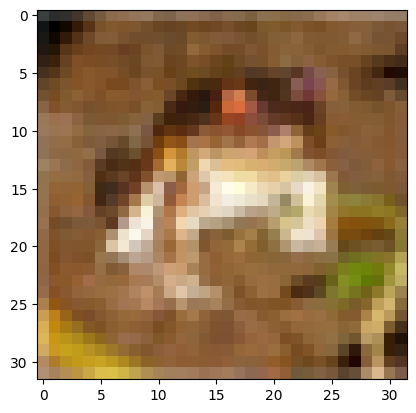

In [ ]:
image, label = trainset[0] #since each element of the trainset list is itself a tuple with the image details, and then the label
print("this is an image of a " + classes[label]) # first index into tuple in trainset, then the 2nd value (label), and then the classes
plt.imshow(image)

## Transform image to matrix of color value

In [ ]:
import torchvision.transforms as transforms

In [ ]:
trainsetT = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testsetT = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("row[0] of trainTransform is tuple with: ", trainsetT[0][0].shape, ",", trainsetT[0][1])

Files already downloaded and verified
Files already downloaded and verified
row[0] of trainTransform is tuple with:  torch.Size([3, 32, 32]) , 6


this is an image of a bird


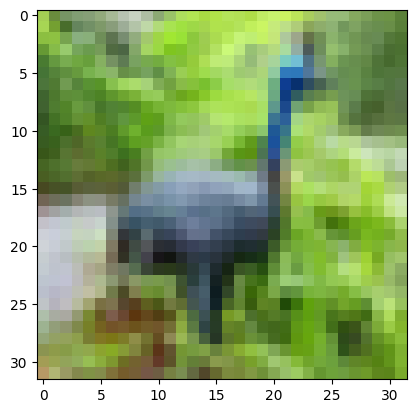

In [ ]:
imgIndex = 6
imgTensor, label = trainsetT[imgIndex]
# plt.imshow(imgTensor)
plt.imshow(imgTensor.permute(1, 2, 0))  # Need to change to right format of plt: Height, With, Channels

print("this is an image of a " + classes[label])

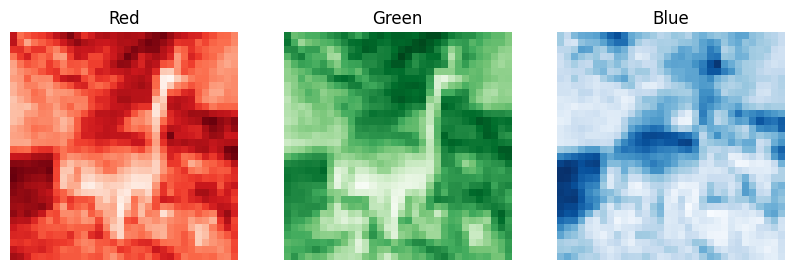

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))  # 1 row, 3 columns


axes[0].imshow(imgTensor[0, :, :], cmap='Reds')  # Red channel
axes[0].set_title('Red')
axes[0].axis('off')  # Turn off axis ticks and labels

axes[1].imshow(imgTensor[1, :, :], cmap='Greens')  # Green channel
axes[1].set_title('Green')
axes[1].axis('off')

axes[2].imshow(imgTensor[2, :, :], cmap='Blues')  # Blue channel
axes[2].set_title('Blue')
axes[2].axis('off')

plt.show()

## Split to Train and Valid dataset

In [ ]:
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split #can use this lib for seprate with same ratio or split valid_size end items.

splitRate = 0.1
m = int(len(trainsetT))
valid_size = int(m * splitRate)

train, val = random_split(trainsetT, [m - valid_size, valid_size])
# train, val = trainsetT[:m - valid_size], trainsetT[m - valid_size:]

test = testsetT

print("length of train dataset: ", len(train))
print("length of valid dataset: ", len(val))
print("length of test dataset: ", len(test))
print(train[0][0].shape, val[0][1])

length of train dataset:  45000
length of valid dataset:  5000
length of test dataset:  10000
torch.Size([3, 32, 32]) 6


In [ ]:
# distributed of each label in train and valid set

train_labels = [label for image, label in train]
val_labels = [label for image, label in val]
test_labels = [label for image, label in test]

train_label_counts = {classes[label]: train_labels.count(label) for label in range(nClasses)}
val_label_counts = {classes[label]: val_labels.count(label) for label in range(nClasses)}
test_label_counts = {classes[label]: test_labels.count(label) for label in range(nClasses)}

print("train label counts: ", train_label_counts)
print("val label counts: ", val_label_counts)
print("test label counts: ", test_label_counts)

train label counts:  {'plane': 4498, 'car': 4511, 'bird': 4513, 'cat': 4499, 'deer': 4507, 'dog': 4502, 'frog': 4489, 'horse': 4497, 'ship': 4486, 'truck': 4498}
val label counts:  {'plane': 502, 'car': 489, 'bird': 487, 'cat': 501, 'deer': 493, 'dog': 498, 'frog': 511, 'horse': 503, 'ship': 514, 'truck': 502}
test label counts:  {'plane': 1000, 'car': 1000, 'bird': 1000, 'cat': 1000, 'deer': 1000, 'dog': 1000, 'frog': 1000, 'horse': 1000, 'ship': 1000, 'truck': 1000}


## Train with scikit-learn
- Sử dụng hướng dẫn của thầy Hoàng trong notebook Classification.

In [ ]:
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

Chuẩn bị dữ liệu

In [ ]:
X_train = np.array([image.numpy().flatten() for image, label in train])
y_train = np.array([label for image, label in train])

X_val = np.array([image.numpy().flatten() for image, label in val])
y_val = np.array([label for image, label in val])

# Chuẩn hóa dữ liệu
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

### Phân lớp bằng Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(multi_class="multinomial")
clf.fit(X_train_std, y_train)

print("Train accuracy: %.3f" % accuracy_score(y_train, clf.predict(X_train_std)))
print("Test accuracy: %.3f" % accuracy_score(y_val, clf.predict(X_val_std)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train accuracy: 0.465
Test accuracy: 0.402


Confusion Matrix

Train accuracy: 0.465


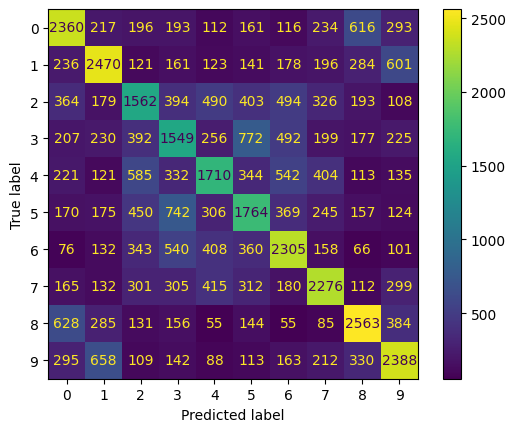

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = clf.predict(X_train_std)
print("Train accuracy: %.3f" % accuracy_score(y_train, y_train_pred))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

### Train with SVM (Only for try)

In [ ]:
from sklearn.svm import SVC

model_name = "svm-rbf-CIFAR10"
if os.path.exists(os.path.join(model_folder, model_name + ".pkl")):
    print("Load model from file")
    clf = pickle.load(open(os.path.join(model_folder, model_name + ".pkl"), "rb"))
else:
  print("Train model")
  clf = SVC(kernel="rbf")
  clf.fit(X_train_std, y_train)
  try:
    with open(os.path.join(model_folder, f"{model_name}.pkl"), "wb") as f:
      pickle.dump(clf, f)
    print(f"Save model {model_name} successfully!")
  except Exception as e:
    print("Error: ", e)
    print("Could not save model to file")


print('Start evaluate')
print("Train accuracy: %.3f" % accuracy_score(y_train, clf.predict(X_train_std)))
print("Test accuracy: %.3f" % accuracy_score(y_val, clf.predict(X_val_std)))

Load model from file
Start evaluate


### Train with RandomForest (Only for try)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_name = "randomforest-CIFAR10"
rf_clf = None
if os.path.exists(os.path.join(model_folder, model_name + ".pkl")):
    print("Load model from file")
    rf_clf = pickle.load(open(os.path.join(model_folder, model_name + ".pkl"), "rb"))
else:
    print("Train model")
  rf_clf = RandomForestClassifier(n_jobs=-1)
  rf_clf.fit(X_train_std, y_train)
  try:
    with open(os.path.join(model_folder, f"{model_name}.pkl"), "wb") as f:
      pickle.dump(rf_clf, f)
    print(f"Save model {model_name} successfully!")
  except Exception as e:
    print("Error: ", e)
    print("Could not save model to file")

print('Start evaluate')
print("Train accuracy: %.3f" % accuracy_score(y_train, rf_clf.predict(X_train_std)))
print("Test accuracy: %.3f" % accuracy_score(y_val, rf_clf.predict(X_val_std)))

### Split data to small batch

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100

train_loader = DataLoader(train, batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size)

for image,label in train_loader:
    print(image.shape)
    break